In [21]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

from scipy.stats import norm

import pickle

In [2]:
nfit = 789
nval = 9
pred_int = 70
tas = np.load('../data/saved/t2m_obs.npy', mmap_mode = 'r')[nfit:(nfit + pred_int),]
# tas = np.array(tas)

pr = np.load('../data/saved/pr_obs.npz.npy', mmap_mode = 'r')[nfit:(nfit + pred_int),]
# pr = np.array(pr)

In [3]:
nlat = tas.shape[1]
nlon = tas.shape[2]
nlat, nlon

(721, 1440)

In [4]:
pred_int = 70
scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
scale /= np.mean(scale)
scale = scale.reshape((1, -1, 1))

In [5]:
### load predictions
tas_nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
tas_lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]
tas_ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]

pr_nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')[0:pred_int]
pr_lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]
pr_ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:(nval+pred_int)]


### load UQ
tas_nngpvar = np.load('./tas_predictions/nngp_predvar.npy', mmap_mode = 'r')[0:pred_int]
tas_lmvar = np.load('./tas_predictions/lm_predvar.npy', mmap_mode = 'r')
tas_ensvar = np.load('./tas_predictions/ens_predvar.npy', mmap_mode = 'r')[nval:(nval+pred_int)]

pr_nngpvar = np.load('./pr_predictions/nngp_predvar.npy', mmap_mode = 'r')[0:pred_int]
pr_lmvar = np.load('./pr_predictions/lm_predvar.npy', mmap_mode = 'r')
pr_ensvar = np.load('./pr_predictions/ens_predvar.npy', mmap_mode = 'r')[nval:(nval+pred_int)]

In [7]:
### mse
tas_mse = [np.mean((tas_nngp - tas)**2 * scale, axis = (1, 2)),
              np.mean((tas_lm - tas)**2 * scale, axis = (1, 2)),
              np.mean((tas_ens - tas)**2 * scale, axis = (1, 2))]

### ssim
tas_ssim = [np.array([ssim(tas[i].astype('float32'), tas_nngp[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(tas[i].astype('float32'), tas_lm[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(tas[i].astype('float32'), tas_ens[i].astype('float32')) for i in trange(pred_int)])]

### mse
pr_mse = [np.mean((pr_nngp - pr)**2 * scale, axis = (1, 2)),
              np.mean((pr_lm - pr)**2 * scale, axis = (1, 2)),
              np.mean((pr_ens - pr)**2 * scale, axis = (1, 2))]

### ssim
pr_ssim = [np.array([ssim(pr[i].astype('float32'), pr_nngp[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(pr[i].astype('float32'), pr_lm[i].astype('float32')) for i in trange(pred_int)]),
               np.array([ssim(pr[i].astype('float32'), pr_ens[i].astype('float32')) for i in trange(pred_int)])]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [8]:
def empirical_coverage(y, yhat, ysig):
    lb = yhat - 1.96 * ysig
    ub = yhat + 1.96 * ysig
    oob = (y > ub) + (y < lb)
    oob = oob * scale
    cover = 1-np.mean(oob, axis = (1, 2))
    return cover

In [9]:
### crps
tas_crps = [np.mean(ps.crps_gaussian(tas, tas_nngp, tas_nngpvar[:,None,None]), axis = (1, 2)),
            np.mean(ps.crps_gaussian(tas, tas_lm, tas_lmvar), axis = (1, 2)),
            np.mean(ps.crps_gaussian(tas, tas_ens, tas_ensvar), axis = (1, 2))]

### cover
tas_cover = [empirical_coverage(tas, tas_nngp, tas_nngpvar[:,None,None]),
             empirical_coverage(tas, tas_lm, tas_lmvar),
             empirical_coverage(tas, tas_ens, tas_ensvar)]

### crps
pr_crps = [np.mean(ps.crps_gaussian(pr, pr_nngp, pr_nngpvar[:,None,None]) * scale, axis = (1, 2)),
            np.mean(ps.crps_gaussian(pr, pr_lm, pr_lmvar) * scale, axis = (1, 2)),
            np.mean(ps.crps_gaussian(pr, pr_ens, pr_ensvar) * scale, axis = (1, 2))]

### cover
pr_cover = [empirical_coverage(pr, pr_nngp, pr_nngpvar[:,None,None]),
             empirical_coverage(pr, pr_lm, pr_lmvar),
             empirical_coverage(pr, pr_ens, pr_ensvar)]


In [44]:
from jax.scipy.special import ndtr as ndtr

def normal_cdf(x, m, s):
    x = (x - m) / s
    return np.array(ndtr(x))

def pit_image(y, yhat, ysig):
    score = normal_cdf(y, yhat, ysig)
    emp_hist = np.histogram(score.flatten(), density=True)[0]
    return np.sqrt(np.mean((emp_hist - 1)**2))

In [45]:
pit_nngp = [pit_image(tas[i], tas_nngp[i], tas_nngpvar[i]) for i in trange(tas.shape[0])]
pit_lm = [pit_image(tas[i], tas_lm[i], tas_lmvar[i]) for i in trange(tas.shape[0])]
pit_ens = [pit_image(tas[i], tas_ens[i], tas_ensvar[i]) for i in trange(tas.shape[0])]

tas_pit = [pit_nngp, pit_lm, pit_ens]

pit_nngp = [pit_image(pr[i], pr_nngp[i], pr_nngpvar[i]) for i in trange(pr.shape[0])]
pit_lm = [pit_image(pr[i], pr_lm[i], pr_lmvar[i]) for i in trange(pr.shape[0])]
pit_ens = [pit_image(pr[i], pr_ens[i], pr_ensvar[i]) for i in trange(pr.shape[0])]

pr_pit = [pit_nngp, pit_lm, pit_ens]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [46]:
tas_metrics = [tas_mse, tas_ssim, tas_crps, tas_cover, tas_pit]
pr_metrics = [pr_mse, pr_ssim, pr_crps, pr_cover, pr_pit]

In [47]:
tas_msemaps = [np.mean((tas_nngp - tas)**2, axis = 0),
              np.mean((tas_lm  - tas)**2, axis = 0),
              np.mean((tas_ens  - tas)**2, axis = 0)]

pr_msemaps = [np.mean((pr_nngp - pr)**2, axis = 0),
              np.mean((pr_lm  - pr)**2, axis = 0),
              np.mean((pr_ens  - pr)**2, axis = 0)]

In [48]:
top = cm.get_cmap('bone', 128)
bottom = cm.get_cmap('OrRd', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 100)),
#                        [1,1,1,1],
                       bottom(np.linspace(0, 1, 100))))
newcmp = ListedColormap(newcolors)

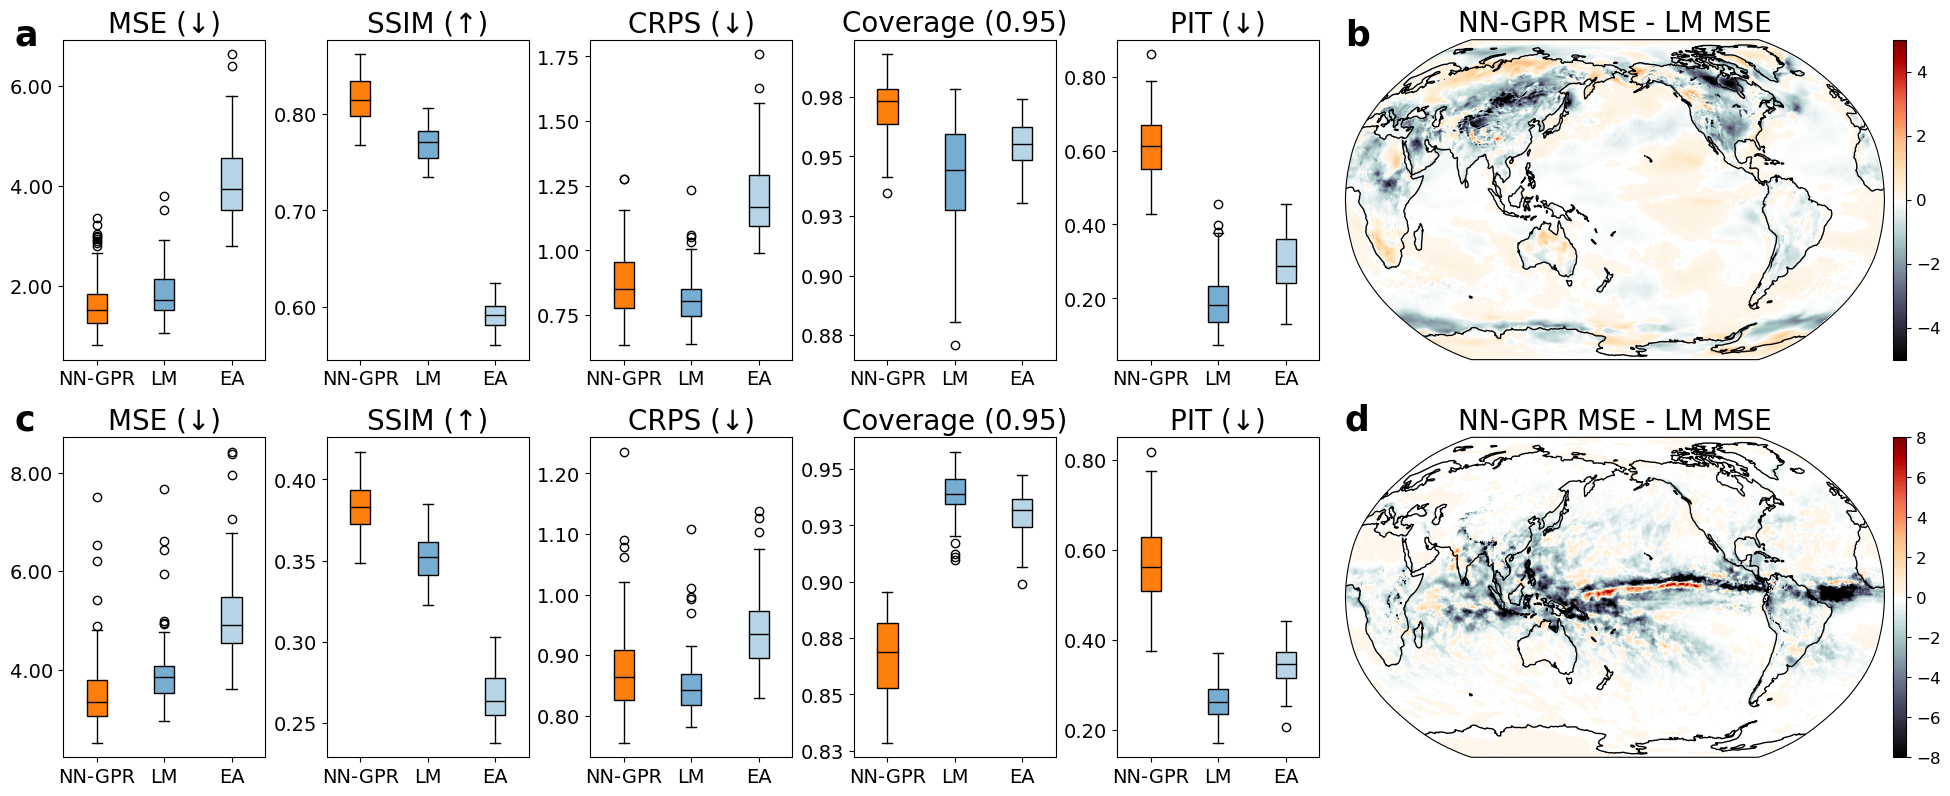

In [62]:
####### boxplots
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


# color the plots
plt_colors = ['C1', '#1f77b499', '#1f77b450']
titles = ['MSE (\u2193)', 'SSIM (\u2191)', 'CRPS (\u2193)', 'Coverage (0.95)', 'PIT (\u2193)']
models = ['NN-GPR', 'LM', 'EA']

data_crs = ccrs.PlateCarree(central_longitude=180)
plot_crs = ccrs.Robinson(central_longitude=180)

fig = plt.figure(constrained_layout = True, figsize = (20, 8))
gs = GridSpec(2, 8, width_ratios = [0.75, 0.75, 0.75, 0.75, 0.75, 1, 1, 0.05], figure = fig)

######### TAS
ax = plt.subplot(gs[0, 0])
ax.text(0.035, 0.932, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(tas_metrics):
    ax = plt.subplot(gs[0, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 14)
    ax.set_title(titles[i], fontsize = 20)
    ax.locator_params(axis='y', nbins = 6)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])
    
    
error_diff = (tas_msemaps[0] - tas_msemaps[1]) * scale
divnorm = colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
cmap = plt.get_cmap('RdBu_r', 9) 
    
ax = plt.subplot(gs[0, (i+1):7], projection=plot_crs)
ax.text(0.7, 0.932, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

im = ax.imshow(error_diff[0], 
               cmap = newcmp, 
               norm = divnorm,
               origin='upper', 
               transform = data_crs)
ax.coastlines()
ax.set_aspect('auto', adjustable=None)
ax.set_title('NN-GPR MSE - LM MSE', fontsize = 20)


ax = plt.subplot(gs[0, 7])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)


######### PR
ax = plt.subplot(gs[1, 0])
ax.text(0.035, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)

for i, metric in enumerate(pr_metrics):
    ax = plt.subplot(gs[1, i])
    bp = ax.boxplot(metric, patch_artist=True, labels=models)
    ax.tick_params(axis='both', which='major', labelsize = 14)
    ax.set_title(titles[i], fontsize = 20)
    ax.locator_params(axis='y', nbins = 6)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    set_box_color(bp, 'black')
    bp['boxes'][0].set_facecolor(plt_colors[0])
    bp['boxes'][1].set_facecolor(plt_colors[1])
    bp['boxes'][2].set_facecolor(plt_colors[2])
    
    
error_diff = (pr_msemaps[0] - pr_msemaps[1]) * scale
divnorm = colors.TwoSlopeNorm(vmin=-8, vcenter=0, vmax=8)
cmap = plt.get_cmap('RdBu_r', 9) 
    
ax = plt.subplot(gs[1, (i+1):7], projection=plot_crs)
ax.text(0.7, 0.45, 'd', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
im = ax.imshow(error_diff[0],
               cmap = newcmp, 
               norm = divnorm,
               origin='upper', 
               transform = data_crs)
ax.coastlines()
ax.set_aspect('auto', adjustable=None)
ax.set_title('NN-GPR MSE - LM MSE', fontsize = 20)


ax = plt.subplot(gs[1, 7])
cbar = plt.colorbar(im, cax=ax)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [32]:
tas_bias = [np.mean((tas_nngp - tas) * scale, axis = (1, 2)),
              np.mean((tas_lm - tas) * scale, axis = (1, 2)),
              np.mean((tas_ens - tas) * scale, axis = (1, 2))]

tas_std = [np.std((tas_nngp - tas) * scale, axis = (1, 2)),
              np.std((tas_lm - tas) * scale, axis = (1, 2)),
              np.std((tas_ens - tas) * scale, axis = (1, 2))]

tas_max = [np.max((tas_nngp - tas) * scale, axis = (1, 2)),
              np.max((tas_lm - tas) * scale, axis = (1, 2)),
              np.max((tas_ens - tas) * scale, axis = (1, 2))]

pr_bias = [np.mean((pr_nngp - pr) * scale, axis = (1, 2)),
              np.mean((pr_lm - pr) * scale, axis = (1, 2)),
              np.mean((tas_ens - pr) * scale, axis = (1, 2))]

pr_std = [np.std((pr_nngp - pr) * scale, axis = (1, 2)),
              np.std((pr_lm - pr) * scale, axis = (1, 2)),
              np.std((pr_ens - pr) * scale, axis = (1, 2))]

pr_max = [np.max((pr_nngp - pr) * scale, axis = (1, 2)),
              np.max((pr_lm - pr) * scale, axis = (1, 2)),
              np.max((pr_ens - pr) * scale, axis = (1, 2))]

In [34]:
print([np.round(np.mean(x), 2) for x in tas_mse])
print([np.round(np.mean(x), 2) for x in tas_ssim])
print([np.round(np.mean(x), 2) for x in tas_crps])
print([np.round(np.mean(x), 2) for x in tas_cover])
print([np.round(np.mean(x), 2) for x in tas_bias])
print([np.round(np.mean(x), 2) for x in tas_std])
print([np.round(np.mean(x), 2) for x in tas_max])

[1.69, 1.88, 4.07]
[0.82, 0.77, 0.59]
[0.88, 0.82, 1.21]
[0.97, 0.94, 0.95]
[-0.07, 0.03, 0.38]
[1.17, 1.25, 1.97]
[9.26, 10.59, 28.8]


In [35]:
print([np.round(np.mean(x), 2) for x in pr_mse])
print([np.round(np.mean(x), 2) for x in pr_ssim])
print([np.round(np.mean(x), 2) for x in pr_crps])
print([np.round(np.mean(x), 2) for x in pr_cover])
print([np.round(np.mean(x), 2) for x in pr_bias])
print([np.round(np.mean(x), 2) for x in pr_std])
print([np.round(np.mean(x), 2) for x in pr_max])

[3.56, 3.99, 5.16]
[0.38, 0.35, 0.27]
[0.88, 0.85, 0.94]
[0.87, 0.94, 0.93]
[-0.0, -0.11, 13.1]
[2.27, 2.4, 2.75]
[39.31, 42.24, 23.38]
